In [3]:
import pandas as pd
# pandas is a software library written for the Python programming language for data manipulation and analysis.
# In this code we use it to show scatter plots. 
import seaborn as sb 
from matplotlib import pyplot as plt # We use matplotlib for create axe and figures to plot data
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col # For use the column name of the dataframe in pyspark
from pyspark.sql import SparkSession

In [4]:
sqlCtx = SparkSession.builder.getOrCreate()

In [8]:
# Here again we use infraschema becouse we need all columns to be double. 
new_data5 = sqlCtx.read.option('header','true').csv('new_data5.csv', inferSchema=True)
new_data5.show()

# print(boston_housing.dtypes)
print(new_data5.dtypes)

+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|   MultipleLines|       OnlineBackup|   DeviceProtection|        TechSupport|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|4472-LVYGI|     1|            0|         0|     0|           1|No phone service|                 No|                Yes|                Yes|                 No|      Two year|               0|Bank transfer (au...|         1.0|    1|
|3115-CZMZD|     0|            0|         0|     0|           0|

<AxesSubplot:>

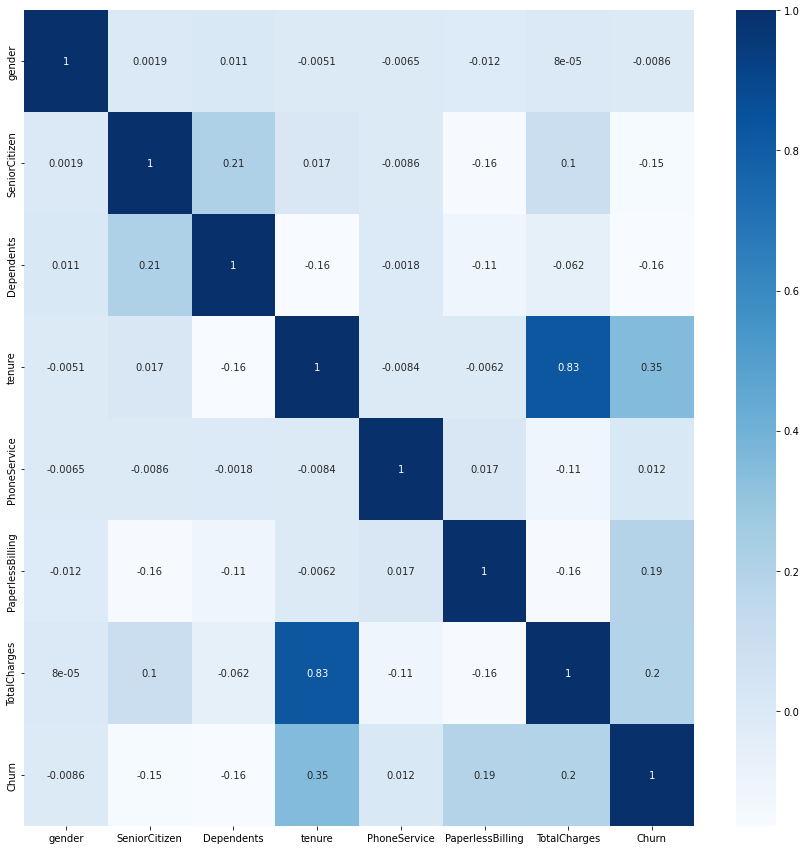

In [9]:
new_data5_pandas_dataframe = new_data5.toPandas()

fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(new_data5_pandas_dataframe.corr(), cmap="Blues", annot=True, ax=ax)

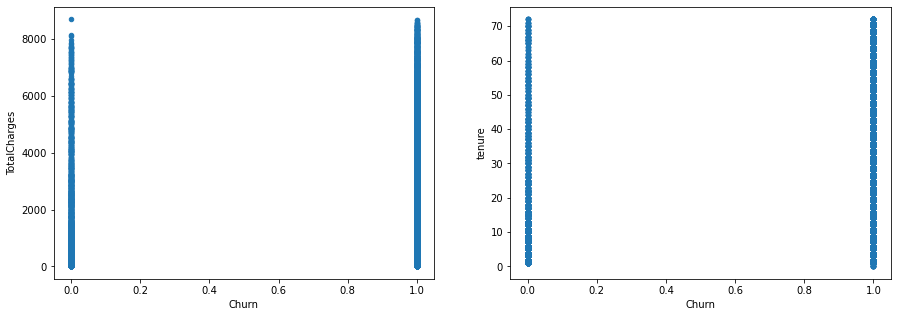

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

new_data5_pandas_dataframe.plot.scatter(x='Churn', y='TotalCharges', ax=ax[0])
new_data5_pandas_dataframe.plot.scatter(x='Churn', y='tenure', ax=ax[1])

plt.show()

In [17]:
new_data5 = new_data5.withColumn("TotalCharges2", col("TotalCharges")*col("TotalCharges"))
new_data5 = new_data5.withColumn("tenure2", col("tenure")*col("tenure"))

tenureAssembler = VectorAssembler(inputCols = ['tenure', 'tenure2'] , outputCol='tenure_features')
TotalChargesAssembler = VectorAssembler(inputCols = ['TotalCharges', 'TotalCharges2'] , outputCol='TotalCharges_features')

df_tenure = tenureAssembler.transform(new_data5).select(['Churn', 'tenure_features'])
df_TotalCharges = TotalChargesAssembler.transform(new_data5).select(['Churn', 'TotalCharges_features'])

df_tenure.show()
df_TotalCharges.show()

df_training_TotalCharges, df_test_TotalCharges = df_TotalCharges.randomSplit([0.7, 0.3])
df_training_tenure, df_test_tenure = df_tenure.randomSplit([0.7, 0.3])

+-----+---------------+
|Churn|tenure_features|
+-----+---------------+
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      (2,[],[])|
|    1|      [1.0,1.0]|
|    1|      [1.0,1.0]|
|    0|      [1.0,1.0]|
|    1|      [1.0,1.0]|
|    1|      [1.0,1.0]|
|    1|      [1.0,1.0]|
|    1|      [1.0,1.0]|
|    0|      [1.0,1.0]|
|    1|      [1.0,1.0]|
+-----+---------------+
only showing top 20 rows

+-----+---------------------+
|Churn|TotalCharges_features|
+-----+---------------------+
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1|            [1.0,1.0]|
|    1| 

In [18]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pr = LinearRegression(featuresCol="TotalCharges_features", labelCol="Churn", maxIter=30)
prModel = pr.fit(df_training_TotalCharges)


print("Coefficients: " + str(prModel.coefficients))
print("Intercept: " + str(prModel.intercept)) # Describe Intercept 

print("r2:", prModel.summary.r2)

Coefficients: [8.778850251315704e-05,-7.326744343653873e-09]
Intercept: 0.6147956832081013
r2: 0.04535358172611392


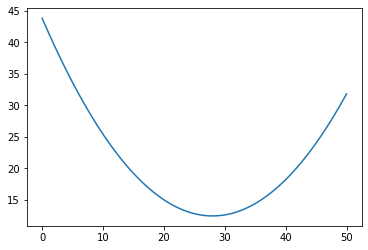

In [19]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(0, 50, 100)
fx = []
for i in range(len(x)):
    fx.append(0.04*x[i]*x[i] - 2.24*x[i] + 43.78)
plt.plot(x, fx)
plt.show()

In [20]:
pr_predictions = prModel.transform(df_test_TotalCharges)
pr_predictions.show()

pr_predictions.select("prediction", "Churn", "TotalCharges_features").show(5)

pr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Churn",metricName="r2")

print("R2 on test data:", pr_evaluator.evaluate(pr_predictions))

+-----+---------------------+------------------+
|Churn|TotalCharges_features|        prediction|
+-----+---------------------+------------------+
|    0| [19.55,382.202500...|0.6165091481322285|
|    0| [19.65,386.122499...| 0.616517898261642|
|    0| [19.65,386.122499...| 0.616517898261642|
|    0|     [19.75,390.0625]|0.6165266482445206|
|    0|        [19.8,392.04]|0.6165310231810093|
|    0| [19.9,396.0099999...|0.6165397729440856|
|    0| [19.9,396.0099999...|0.6165397729440856|
|    0| [20.1,404.0100000...|0.6165572720306335|
|    0| [20.15,406.022499...|0.6165616467106861|
|    0| [20.15,406.022499...|0.6165616467106861|
|    0| [20.2,408.0399999...|0.6165660213541051|
|    0|     [20.25,410.0625]|0.6165703959608904|
|    0| [20.4,416.1599999...|0.6165835195614436|
|    0|        [20.5,420.25]|0.6165922684453106|
|    0|        [20.5,420.25]|0.6165922684453106|
|    0|     [20.55,422.3025]|0.6165966428322935|
|    0| [20.6,424.3600000...|0.6166010171826427|
|    0| [20.85,434.7